In [3]:
# Imports
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Preprocessing

In [59]:
data_1hour = pd.read_csv(Path("../Data/electricitybalancenonv_2_1_2022.csv"), sep=',', decimal='.', encoding='utf-8', index_col='HourUTC', parse_dates=True)
data_1hour = data_1hour.drop('HourDK', axis=1)

# Splits the data into the two price areas DK1 and DK2
data_dk1 = data_1hour[data_1hour['PriceArea'] == 'DK1']
data_dk1 = data_dk1.asfreq('1H')

data_dk2 = data_1hour[data_1hour['PriceArea'] == 'DK2']
data_dk2 = data_dk2.asfreq('1H')

# Imputes missing values with average of the same hour from previous and following 3 days
def imputeNA(data, i, column='TotalLoad'):
    other_observations = 0
    for t in range(7):
        if t!= 3:
            other_observations += data[column][data.index[i] - pd.Timedelta(t-3, 'd')]
    data.loc[data.index[i], column] = round(other_observations/6, 2)
    return data

def fillnaTotalLoad(data):
    for i in range(len(data)):
        if pd.isna(data.TotalLoad[data.index[i]]):
            data = imputeNA(data, i)
    return data

def changeOutliers(data, columns):
    for i in range(len(data)):
        if data.TotalLoad[data.index[i]] > 10000:
            for column in columns:
                data = imputeNA(data, i, column)
    return data

def changeNA(data, columns):
    for i in range(len(data)):
        if pd.isna(data.ExchangeNordicCountries[data.index[i]]):
            for column in columns:
                if pd.isna(data[column][data.index[i]]):
                    data = imputeNA(data, i, column)
    return data

In [60]:
data_dk1 = fillnaTotalLoad(data_dk1)
data_dk1 = data_dk1.drop('PriceArea', axis=1)
data_dk1

,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,1892.60,204.30,220.77,355.35,10.70,2.0,2.97,0.00,108.07,1070.10,657.25,-1263.0,282.0,990.0
2020-01-01 01:00:00+00:00,1830.97,163.25,220.24,336.92,10.74,2.0,2.91,0.00,106.29,1273.98,749.12,-1339.0,326.0,731.0
2020-01-01 02:00:00+00:00,1782.09,157.09,219.65,329.49,10.76,2.0,2.77,0.00,107.20,1568.97,829.06,-1393.0,394.0,295.0
2020-01-01 03:00:00+00:00,1745.69,163.37,220.16,321.75,10.73,2.0,2.76,0.00,106.83,1732.34,898.73,-1118.0,158.0,-41.0
2020-01-01 04:00:00+00:00,1781.79,172.77,222.83,369.13,10.87,2.0,2.78,0.00,117.44,1852.97,887.99,-1141.0,-71.0,-485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2301.86,206.49,154.31,224.50,11.32,1.0,2.20,0.73,99.80,859.29,795.78,-177.0,597.0,-225.0
2021-12-31 20:00:00+00:00,2211.26,153.95,146.71,187.90,10.90,1.0,2.14,0.73,99.02,693.77,791.86,50.0,597.0,-268.0
2021-12-31 21:00:00+00:00,2154.02,228.84,154.46,171.63,10.86,1.0,2.10,0.72,99.39,624.31,992.84,-361.0,593.0,-154.0


In [61]:
data_dk1 = changeOutliers(data_dk1, columns=['TotalLoad', 'Biomass', 'FossilGas', 'FossilHardCoal', 'FossilOil', 'OtherRenewable', 'Waste'])
data_dk1 = changeNA(data_dk1, data_dk1.columns)
data_dk1

,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,1892.60,204.30,220.77,355.35,10.70,2.0,2.97,0.00,108.07,1070.10,657.25,-1263.0,282.0,990.0
2020-01-01 01:00:00+00:00,1830.97,163.25,220.24,336.92,10.74,2.0,2.91,0.00,106.29,1273.98,749.12,-1339.0,326.0,731.0
2020-01-01 02:00:00+00:00,1782.09,157.09,219.65,329.49,10.76,2.0,2.77,0.00,107.20,1568.97,829.06,-1393.0,394.0,295.0
2020-01-01 03:00:00+00:00,1745.69,163.37,220.16,321.75,10.73,2.0,2.76,0.00,106.83,1732.34,898.73,-1118.0,158.0,-41.0
2020-01-01 04:00:00+00:00,1781.79,172.77,222.83,369.13,10.87,2.0,2.78,0.00,117.44,1852.97,887.99,-1141.0,-71.0,-485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2301.86,206.49,154.31,224.50,11.32,1.0,2.20,0.73,99.80,859.29,795.78,-177.0,597.0,-225.0
2021-12-31 20:00:00+00:00,2211.26,153.95,146.71,187.90,10.90,1.0,2.14,0.73,99.02,693.77,791.86,50.0,597.0,-268.0
2021-12-31 21:00:00+00:00,2154.02,228.84,154.46,171.63,10.86,1.0,2.10,0.72,99.39,624.31,992.84,-361.0,593.0,-154.0


In [34]:
data_dk1['2020-02-27 10:00:00+00:00':'2020-02-27 18:00:00+00:00']

,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,
2020-02-27 10:00:00+00:00,3192.48,307.51,443.84,975.95,13.54,3.51,4.12,209.64,128.34,184.07,118.32,132.0,-290.0,904.0
2020-02-27 11:00:00+00:00,3043.91,309.79,532.91,1053.04,15.59,3.51,4.30,270.96,142.82,235.70,80.56,-451.0,-566.0,1364.0
2020-02-27 12:00:00+00:00,3092.25,308.03,502.55,978.91,14.35,3.50,4.59,254.80,140.95,250.95,66.47,140.0,-582.0,956.0
2020-02-27 13:00:00+00:00,2796.38,219.03,269.79,561.46,11.08,3.50,3.67,194.99,86.10,204.72,99.62,332.0,-538.0,939.0
2020-02-27 14:00:00+00:00,2921.25,310.62,523.41,757.31,14.87,3.50,4.56,129.31,133.00,164.36,126.22,-8.0,-286.0,1049.0
2020-02-27 15:00:00+00:00,2925.02,313.38,553.78,855.72,14.73,3.50,4.57,52.96,132.76,155.58,407.27,-246.0,-303.0,975.0
2020-02-27 16:00:00+00:00,3045.90,313.80,604.01,942.66,14.84,3.50,4.34,7.89,145.15,139.44,454.20,150.0,-405.0,668.0
2020-02-27 17:00:00+00:00,3184.40,312.43,566.63,980.33,15.07,3.50,4.25,0.07,135.69,198.28,593.80,-360.0,-359.0,1086.0
2020-02-27 18:00:00+00:00,3033.17,312.62,554.57,940.28,15.06,3.49,4.46,0.00,134.89,303.86,538.17,-754.0,-313.0,1283.0


In [73]:
data_dk1[data_dk1.TotalLoad.isna()]

,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,


In [46]:
data_dk1.index

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 01:00:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 03:00:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 05:00:00+00:00',
               '2020-01-01 06:00:00+00:00', '2020-01-01 07:00:00+00:00',
               '2020-01-01 08:00:00+00:00', '2020-01-01 09:00:00+00:00',
               ...
               '2021-12-31 14:00:00+00:00', '2021-12-31 15:00:00+00:00',
               '2021-12-31 16:00:00+00:00', '2021-12-31 17:00:00+00:00',
               '2021-12-31 18:00:00+00:00', '2021-12-31 19:00:00+00:00',
               '2021-12-31 20:00:00+00:00', '2021-12-31 21:00:00+00:00',
               '2021-12-31 22:00:00+00:00', '2021-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='HourUTC', length=17544, freq='H')

# Predict TotalLoad according to day

In [85]:
data_dk1.index.strftime('%H')

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       ...
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object', name='HourUTC', length=17544)

In [87]:
date_index = data_dk1.index
data_dk1["Year"] = date_index.strftime('%Y')
data_dk1["Month"] = date_index.strftime('%m')
data_dk1["Day"] = date_index.strftime('%d')
data_dk1["Hour"] = date_index.strftime('%H')
data_dk1["Weekday"] = date_index.day_of_week
data_dk1["Holiday"] = np.isin(date_index.strftime('%Y-%m-%d'), ["2020-01-01", "2020-04-09", "2020-04-10", "2020-04-12",
"2020-04-13", "2020-05-08", "2020-05-21", "2020-05-31", "2020-06-01", "2020-06-05",
"2020-12-24", "2020-12-25", "2020-12-26", "2021-01-01" ,"2021-04-01", "2021-04-02",
"2021-04-04", "2021-04-05", "2021-04-30", "2021-05-13", "2021-05-23", "2021-05-24",
"2021-06-05", "2021-12-24", "2021-12-25", "2021-12-26"])
data_dk1 = data_dk1[["TotalLoad", "Year", "Month", "Day", "Weekday", "Holiday", "Hour"]]
data_dk1

,TotalLoad,Year,Month,Day,Weekday,Holiday,Hour
HourUTC,,,,,,,
2020-01-01 00:00:00+00:00,1892.60,2020,01,01,2,True,00
2020-01-01 01:00:00+00:00,1830.97,2020,01,01,2,True,01
2020-01-01 02:00:00+00:00,1782.09,2020,01,01,2,True,02
2020-01-01 03:00:00+00:00,1745.69,2020,01,01,2,True,03
2020-01-01 04:00:00+00:00,1781.79,2020,01,01,2,True,04
...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2301.86,2021,12,31,4,False,19
2021-12-31 20:00:00+00:00,2211.26,2021,12,31,4,False,20
2021-12-31 21:00:00+00:00,2154.02,2021,12,31,4,False,21


In [88]:
X, y = data_dk1.drop(columns=['TotalLoad']), data_dk1.TotalLoad
X.shape, y.shape

((17544, 6), (17544,))

In [89]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.values.reshape(-1,1))

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
X_ss.shape, y_mm.shape

((17396, 100, 6), (17396, 50))

In [90]:
total_samples = len(X)
train_test_cutoff = round(0.10 * total_samples)

X_train = X_ss[:-train_test_cutoff]
X_test = X_ss[-train_test_cutoff:]

y_train = y_mm[:-train_test_cutoff]
y_test = y_mm[-train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (15642, 100, 6) (15642, 50)
Testing Shape: (1754, 100, 6) (1754, 50)


In [91]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([15642, 100, 6]) torch.Size([15642, 50])
Testing Shape: torch.Size([1754, 100, 6]) torch.Size([1754, 50])


In [92]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
              X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

In [93]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = len(X.columns) # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)


Epoch: 0, train loss: 0.26434, test loss: 0.32594
Epoch: 100, train loss: 0.01966, test loss: 0.02501
Epoch: 200, train loss: 0.01553, test loss: 0.02206
Epoch: 300, train loss: 0.01340, test loss: 0.02091
Epoch: 400, train loss: 0.01180, test loss: 0.01981
Epoch: 500, train loss: 0.01066, test loss: 0.01969
Epoch: 600, train loss: 0.00984, test loss: 0.01997
Epoch: 700, train loss: 0.00934, test loss: 0.02034
Epoch: 800, train loss: 0.00896, test loss: 0.02074
Epoch: 900, train loss: 0.00855, test loss: 0.02096


# Plot

In [104]:
len(data_dk1), len(preds), len(true)

(17544, 17396, 17396)

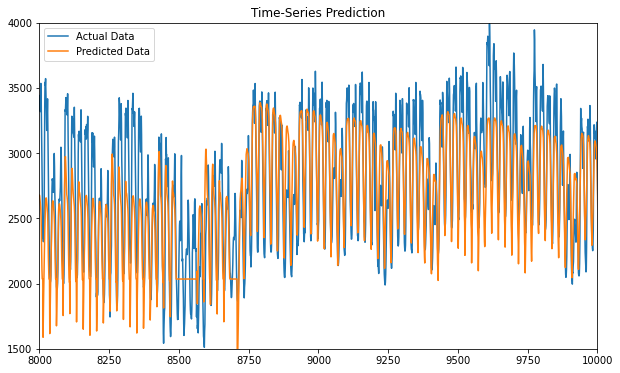

In [97]:
df_X_ss = ss.transform(data_dk1.drop(columns=['TotalLoad'])) # old transformers
df_y_mm = mm.transform(data_dk1.TotalLoad.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=len(data_dk1)-train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.xlim([8000,10000])
plt.ylim(1500, 4000)
plt.show()